# Chicago Divvy Bicycle Sharing Data

#### Link Kaggle
https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

#### Descrição das features:
<br><b>trip_id</b>ID attached to each trip taken
<br><b>year</b> Year
<br><b>month</b> Month
<br><b>week</b> Week No.
<br><b>day</b> Day
<br><b>hour</b> Hour
<br><b>usertype</b> "Customer" is a rider who purchased a 24-Hour Pass; "Subscriber" is a rider who purchased an Annual Membership
<br><b>gender</b>
<br><b>starttimeday</b> and time trip started, in CST
<br><b>stoptimeday</b> and time trip ended, in CST
<br><b>tripdurationtime</b> of trip in minutes
<br><b>temperature</b>
<br><b>events</b>
<br><b>from_station_idID</b> of station where trip originated
<br><b>from_station_namename</b> of station where trip terminated
<br><b>latitude_startstation</b> latitude
<br><b>longitude_startstation</b> longitude
<br><b>dpcapacity_startnumber</b> of total docks at each station
<br><b>to_station_id</b>
<br><b>to_station_name</b>
<br><b>latitude_end</b>
<br><b>longitude_end</b>
<br><b>dpcapacity_endnumber</b> of total docks at each station

### Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

#from sklearn.learning_curve import validation_curve
#from sklearn.learning_curve import learning_curve
#from sklearn.cross_validation import train_test_split
#from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
#from sklearn.cross_validation  import cross_val_score
from sklearn.model_selection  import validation_curve
from sklearn.model_selection  import learning_curve
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection   import cross_val_score

from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

In [2]:
#################### Define Helper Functions
def bs_create_polynomial_terms(l_train, l_test, degree):
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree)
    # details http://scikit-learn.org/stable/modules/linear_model.html
    l_train_poly = poly.fit_transform(l_train) 
    l_test_poly = poly.fit_transform(l_test)
    return l_train_poly, l_test_poly
    
def bs_scale_mean_std(l_train, l_test):
    # read about data scaling here: 
    # http://quant.stackexchange.com/questions/4434/gradient-tree-boosting-do-input-attributes-need-to-be-scaled
    sc = StandardScaler()
    l_train_scaled = pd.DataFrame(sc.fit_transform(l_train))
    l_test_scaled = pd.DataFrame(sc.transform(l_test)) # careful, transform() only.
    return l_train_scaled, l_test_scaled

def bs_fit_and_save(clf, l_train, l_target, l_test, filename):
    # more about it here: http://scikit-learn.org/stable/modules/svm.html#regression
    clf.fit (l_train, l_target)
    # The mean square error
    predict_train = clf.predict(l_train)
    print("Residual sum of squares: %.2f" % np.mean((predict_train - l_target) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % clf.score(l_train, l_target))
    return clf

def bs_accuracy(test, pred):   
    print('Acurácia norm. = {:.2f}'.format(accuracy_score(test, pred)))
    print('Acurácia = {:.0f}'.format(accuracy_score(test, pred, normalize=False)))

def plot_chart_predict(x__plot, model, x_test, y_test, bot, top, desc):
    y_pred = model.predict(x_test)
    v_title = "Predição de viagens - Modelo: " + desc

    
    plt.rcParams["figure.figsize"] = (15,9)
    plt.plot(x__plot['date2'][bot:top], np.exp(np.log(y_test[bot:top])),  color='black', label="Dia Real")
    plt.plot(x__plot['date2'][bot:top], np.exp(y_pred[bot:top]),10, color='blue', linewidth=3,  label="Predição")
    plt.legend(loc='upper right')
    plt.title(v_title, fontsize=16, fontweight='bold')
    plt.xlabel("Dia")
    plt.ylabel("Media Viagens")
    plt.show()    

### Carregar dataset

In [3]:
#Carregar dataset
#path = "data.csv"
path = "../input/data.csv"
df = pd.read_csv(path)

df.shape

(9495235, 23)

In [4]:
#feriados ###############
holidays = [
'2014-01-01','2014-12-25',
'2014-11-11','2014-07-04',
'2014-01-20','2014-02-17',
'2014-03-02','2014-05-26',
'2014-09-01','2014-10-13',
'2014-11-27','2015-01-01',
'2015-12-25','2015-11-11',
'2015-07-04','2015-01-19',
'2015-02-16','2015-03-02',
'2015-05-25','2015-09-07',
'2015-10-12','2015-11-26',
'2016-01-01','2016-12-25',
'2016-11-11','2016-07-04',
'2016-01-18','2016-02-15',
'2016-03-04','2016-05-30',
'2016-09-05','2016-10-10',
'2016-11-24','2017-01-01',
'2017-12-25','2017-11-11',
'2017-07-04','2017-01-16',
'2017-02-20','2017-03-06',
'2017-05-29','2017-09-04',
'2017-10-09','2017-11-23'
]

df_holidays = pd.DataFrame(holidays)
df_holidays['date'] = pd.to_datetime(df_holidays[0]).dt.date
df_holidays['holiday'] = 1
df_holidays = df_holidays.drop([0], axis=1)


#Corringindo campo day com 0
df.day =  df.starttime.astype(str).str.slice(8,10).astype(int)

In [5]:
#Novas features
df.starttime = pd.to_datetime(df.starttime)
df.stoptime  = pd.to_datetime(df.stoptime)
df['date']   = df.starttime.dt.date

#Definição fim de semana
df['weekend'] = np.where(df.starttime.dt.weekday > 4 , 1, 0)

#Inicializando novas features
df['season'] = ''

#Definição estações Hemisfério NORTE  ##########################
for x in range(df.year.min().astype(int), df.year.max().astype(int)+1):
    #Primavera: 21-03 até 20-06
    df.loc[(df.starttime > str(x)+'-03-21 00:00:00') & (df.starttime < str(x)+'-06-20 23:59:59'),  'season'] = 'primavera'
    #Verão:     21-06 até 20-09
    df.loc[(df.starttime > str(x)+'-06-21 00:00:00') & (df.starttime < str(x)+'-09-20 23:59:59'),  'season'] = 'verão'
    #Outono:    21-09 até 20-12
    df.loc[(df.starttime > str(x)+'-09-21 00:00:00') & (df.starttime < str(x)+'-12-20 23:59:59'),  'season'] = 'outono'
    #Inverno:   21-12 até 20-03
    df.loc[(df.starttime > str(x)+'-12-21 00:00:00') & (df.starttime < str(x+1)+'-03-20 23:59:59'),'season'] = 'inverno'
    
    
    
#Junção dos dados com feriados #################################
df_holidays.head()
df_join = df.set_index('date').join(df_holidays.set_index('date'))
df_join['isholiday']  = np.where(df_join.holiday==1, 1, 0)
df_join['regularday'] = np.where(df_join.isholiday+df_join.weekend == 0, 1, 0)

#clear DF ##################################
df.iloc[0:0]
del df

In [6]:
#Label Encoder ##############################
# Replace all male and female genders with '0's and '1's respectively
df_join.loc[df_join["gender"] == "Male", "gender"] = 0
df_join.loc[df_join["gender"] == "Female", "gender"] = 1

# tipo usuario
lb_usertype = LabelEncoder()
df_join["usertype_code"] = lb_usertype.fit_transform(df_join["usertype"])
df_join[["usertype", "usertype_code"]].head(11)

#estação
lb_to_station_name = LabelEncoder()
df_join["to_station_name_code"] = lb_usertype.fit_transform(df_join["to_station_name"])
df_join[["to_station_name", "to_station_name_code"]].head(11)


#estação
#lb_season = LabelEncoder()
#df_join["season_code"] = lb_season.fit_transform(df_join["season"])
#df_join[["season", "season_code"]].head(11)

#lb_date_id = LabelEncoder()
#df_join["lb_date_id_code"] = lb_season.fit_transform(df_join["date_id"])
#df_join[["date_id", "lb_date_id_code"]].head(11)

,to_station_name,to_station_name_code
date,,
2014-01-01,Clarendon Ave & Gordon Ter,115
2014-01-01,Kedzie Ave & Palmer Ct,306
2014-01-01,Clinton St & Madison St,148
2014-01-01,Larrabee St & Kingsbury St,345
2014-01-01,Clark St & Montrose Ave,133
2014-01-01,Lakeview Ave & Fullerton Pkwy,339
2014-01-01,Hampden Ct & Diversey Pkwy,280
2014-01-01,Clark St & Lincoln Ave,131
2014-01-01,Blue Island Ave & 18th St,45


In [7]:
#convert lines into columns
df_join = pd.get_dummies(df_join, columns=["season"])
df_join_del = df_join[df_join['season_'] == 1]
df_join = df_join.drop(df_join_del.index, axis=0)

# convert string to int
df_join[['year', 'month', 'day', 'hour']] = df_join[['year', 'month', 'day', 'hour']].astype(int)

In [8]:
#Agregar informação para modelo
col = [
'year',
 'month',
    'day',
'weekend',
'season_inverno',
'season_outono',
'season_primavera',
'season_verão',
'isholiday',
'regularday'
]

df_join['trip_count'] = 1

#Agregação
df_join_agg1 =  df_join.groupby(col).aggregate({                                         
                                         'trip_count'      : 'sum'
                                        }).reset_index()

In [9]:
#split datasets to train/test and validation
df_join_agg_2017 = df_join_agg1[df_join_agg1.year == 2017]
df_join_agg_2016 = df_join_agg1[df_join_agg1.year != 2017]

In [10]:
y = df_join_agg_2016.trip_count

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df_join_agg_2016, y, test_size=0.25)

X_train = X_train.drop(labels=["trip_count"], axis=1)
X_test = X_test.drop(labels=["trip_count"], axis=1)

#valida
y_valida = df_join_agg_2017.trip_count
X_valida = df_join_agg_2017.drop(labels=["trip_count"], axis=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


x_plot = X_test.copy()
x_plot['date2'] = x_plot['year'].astype(str) +  x_plot['day'].astype(str) +  x_plot['month'].astype(str) 
x_plot2 = X_valida.copy()
x_plot2['date2'] = x_plot2['year'].astype(str) +  x_plot2['day'].astype(str) +  x_plot2['month'].astype(str) 

(757, 10) (757,)
(253, 10) (253,)


In [11]:
X_train.head(5)

,year,month,day,weekend,season_inverno,season_outono,season_primavera,season_verão,isholiday,regularday
33,2014,4,24,0,0,0,1,0,0,1
767,2016,5,3,0,0,0,1,0,0,1
513,2015,8,23,1,0,0,0,1,0,0
853,2016,7,28,0,0,0,0,1,0,1
478,2015,7,19,1,0,0,0,1,0,0


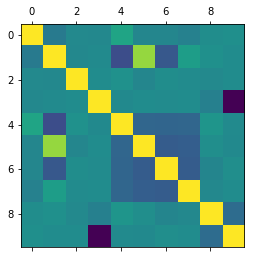

In [12]:
plt.matshow(X_train.corr())
# fit a model
#y_train = np.log(y_train)

In [13]:
lm         = linear_model.LinearRegression()
lm.fit(X_train, np.log(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
## The line / model
y_train   = np.log(y_train)

Mean squared error: 54509860.06
Variance score: -3.43


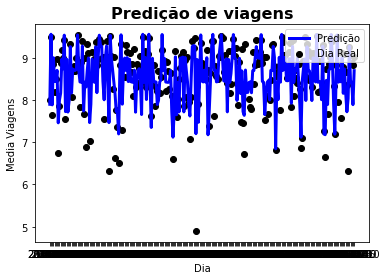

In [15]:
y_pred  = lm.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

plt.scatter(x_plot['date2'], np.log(y_test),  color='black', label="Dia Real")
plt.plot(x_plot['date2'], y_pred, color='blue', linewidth=3,  label="Predição")
plt.rcParams["figure.figsize"] = (15,9)
plt.legend(loc='upper right')
plt.title("Predição de viagens", fontsize=16, fontweight='bold')
plt.xlabel("Dia")
plt.ylabel("Media Viagens")
plt.show()
plt.clf()
plt.cla()
plt.close()

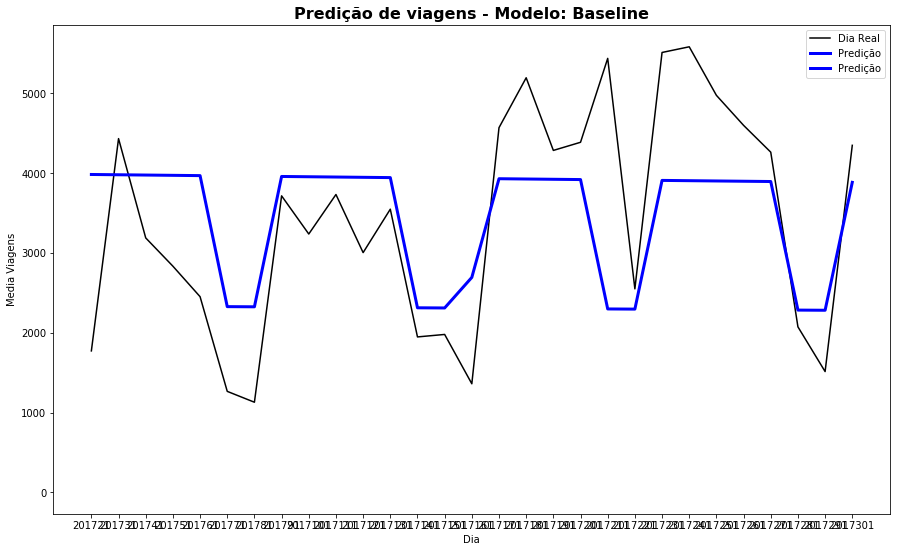

In [16]:

plot_chart_predict(x_plot2, bot=1,top=30,model=lm,x_test=X_valida,y_test=y_valida,desc="Baseline")

Residual sum of squares: 0.22
Variance score: 0.61


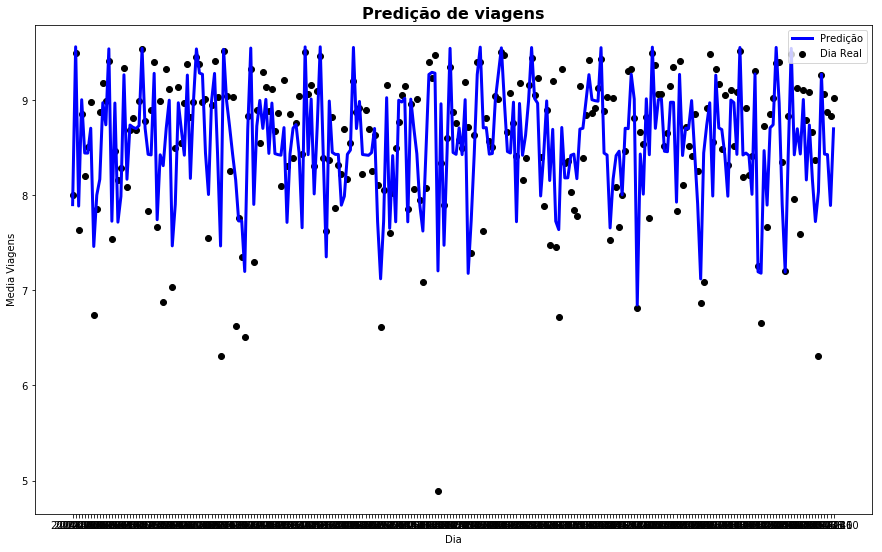

In [17]:
################## Simple Linear Regression
# Since its a regression problem we will first develop simple linear regression

# Create linear regression object
clf1 = linear_model.LinearRegression()

# get fitted regresser
clf1 = bs_fit_and_save(clf1, X_train, y_train, X_test, "output_SLR")
y_pred  = clf1.predict(X_test)


plt.scatter(x_plot['date2'], np.log(y_test),  color='black', label="Dia Real")
plt.plot(x_plot['date2'], y_pred, color='blue', linewidth=3,  label="Predição")

plt.rcParams["figure.figsize"] = (15,9)
plt.legend(loc='upper right')
plt.title("Predição de viagens", fontsize=16, fontweight='bold')
plt.xlabel("Dia")
plt.ylabel("Media Viagens")
plt.show()

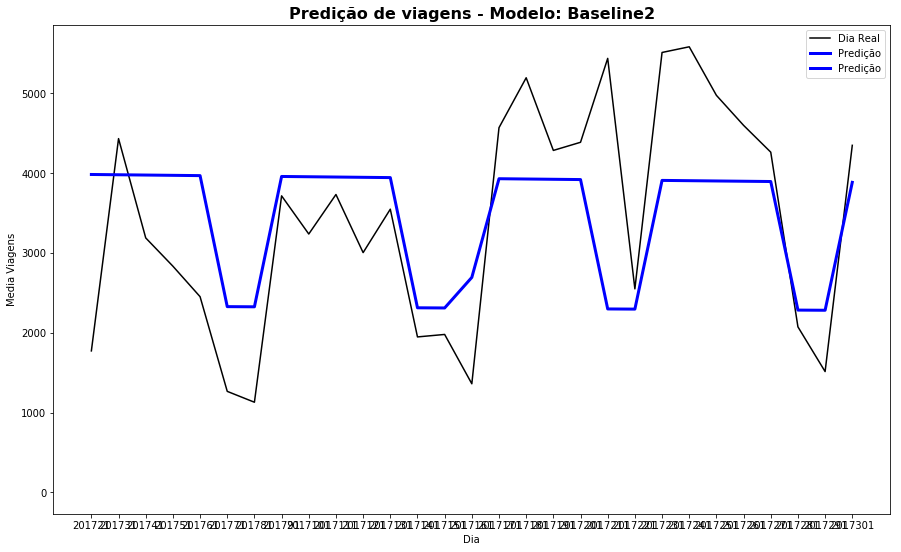

In [18]:
plot_chart_predict(x_plot2, bot=1,top=30,model=clf1,x_test=X_valida,y_test=y_valida,desc="Baseline2")

In [19]:
################## Simple Linear Regression with Ridge Regression

# Now we will perform Ridge Regression
# Unlike simple linear regression, ridge regularization requires scaled data
train_scaled, test_scaled = bs_scale_mean_std(X_train, X_test)

# first we will perform cross-validation to find the best alpha value
clf2 = linear_model.RidgeCV(alphas=[0.0001, 0.001, 0.1, 1.0, 10.0, 100.0, 1000.0])

clf2 = bs_fit_and_save(clf2, train_scaled, y_train, test_scaled, "output_Ridge")

# The coefficients
print('Coefficients: \n', clf2.coef_)
print('Alpha: \n', clf2.alpha_) 



Residual sum of squares: 0.22
Variance score: 0.61
Coefficients: 
 [ 0.21648221 -0.02410371 -0.00858036 -0.57016048 -0.3775334   0.03694692
  0.02015033  0.2808609  -0.18779137 -0.33560669]
Alpha: 
 1.0


In [20]:
################## Simple Linear Regression with Lasso Regression

# Unlike simple linear regression, lasso regularization requires scaled data
train_scaled, test_scaled = bs_scale_mean_std(X_train, X_test)

# first we will perform cross-validation to find the best alpha value
clf3 = linear_model.LassoCV(alphas=[0.001, 0.1, 1.0, 10.0, 100.0, 1000.0])

# get fitted regresser
clf3 = bs_fit_and_save(clf3, train_scaled, y_train, test_scaled, "output_Lasso")

# The coefficients
print('Alpha: \n', clf3.alpha_)  

Residual sum of squares: 0.23
Variance score: 0.61
Alpha: 
 0.001


In [21]:
################## Simple Linear Regression with Polynomial terms

# create polynomial terms
train_poly, test_poly = bs_create_polynomial_terms(X_train, X_test, 2)

# Create linear regression object
clf4 = linear_model.LinearRegression()

# get fitted regresser
clf4 = bs_fit_and_save(clf4, train_poly, y_train, test_poly, "output_poly_d2")

Residual sum of squares: 0.10
Variance score: 0.83


Residual sum of squares: 0.12
Variance score: 0.80


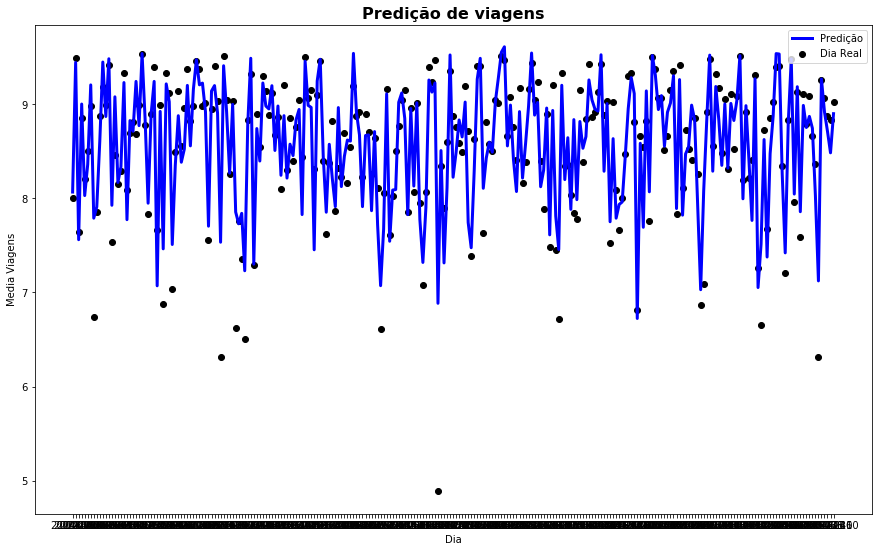

In [22]:
################## Ridge Regression with Polynomial Terms

# create polynomial terms
train_poly, test_poly = bs_create_polynomial_terms(X_train, X_test, 2)

# Ridge regularization requires scaled data
train_scaled, test_scaled = bs_scale_mean_std(train_poly, test_poly)

# Create linear regression object
clf5 = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0])

# get fitted regresser
clf5 = bs_fit_and_save(clf5, train_scaled, y_train, test_scaled, "output_Ridge_poly_2")



y_pred  = clf5.predict(test_scaled)


plt.scatter(x_plot['date2'], np.log(y_test),  color='black', label="Dia Real")
plt.plot(x_plot['date2'], y_pred, color='blue', linewidth=3,  label="Predição")

plt.rcParams["figure.figsize"] = (15,9)
plt.legend(loc='upper right')
plt.title("Predição de viagens", fontsize=16, fontweight='bold')
plt.xlabel("Dia")
plt.ylabel("Media Viagens")
plt.show()

In [23]:
################## Lasso Regression with Polynomial Terms

# create polynomial terms
train_poly, test_poly = bs_create_polynomial_terms(X_train, X_test, 2)

# Lasso regularization requires scaled data
train_scaled, test_scaled = bs_scale_mean_std(train_poly, test_poly)

# Create linear regression object
clf6 = linear_model.LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])

# get fitted regresser
clf6 = bs_fit_and_save(clf6, train_scaled, y_train, test_scaled, "output_lasso_poly_2")

Residual sum of squares: 0.12
Variance score: 0.80


In [24]:
################## Support Vector Regression with Polynomial Terms

# create polynomial terms
train_poly, test_poly = bs_create_polynomial_terms(X_train, X_test, 2)

# SVR requires scaled data
train_scaled, test_scaled = bs_scale_mean_std(train_poly, test_poly)

# Create linear regression object
# ideally these parameters should be determined using cross-validation
clf7 = svm.SVR(kernel='rbf', C=100, gamma=0.01) 

# get fitted regresser
clf7 = bs_fit_and_save(clf7, train_scaled, y_train, test_scaled, "output_svm_poly_2")

Residual sum of squares: 0.08
Variance score: 0.87


Residual sum of squares: 0.02
Variance score: 0.97


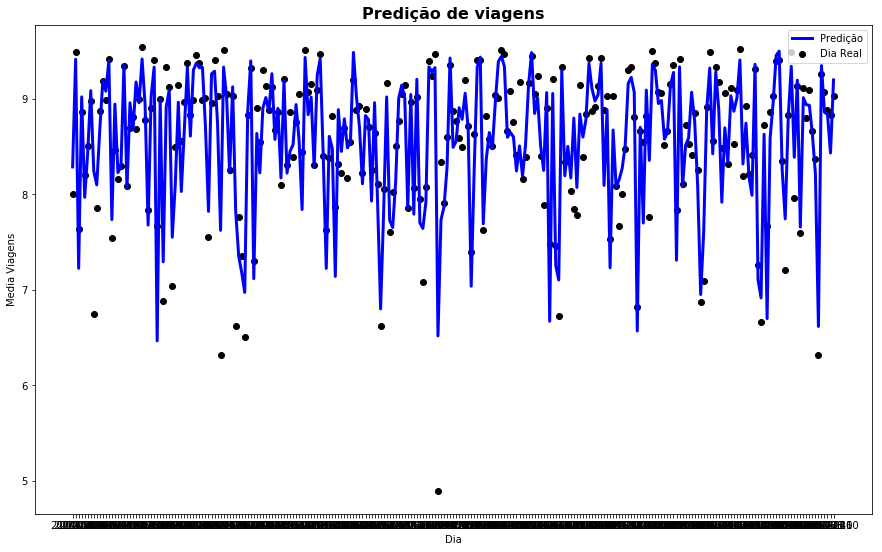

In [25]:
################## Gradient Boosting Regression with Polynomial Terms

# create polynomial terms
train_poly, test_poly = bs_create_polynomial_terms(X_train, X_test, 2)

# Unlike simple linear regression, ridge regularization requires scaled data
train_scaled, test_scaled = bs_scale_mean_std(train_poly, test_poly)

# Create linear regression object
clf8 = GradientBoostingRegressor(n_estimators=350, learning_rate=0.1, 
                                max_depth=3, loss='ls')

# get fitted regresser
clf8 = bs_fit_and_save(clf8, train_scaled, y_train, test_scaled, "output_gbm_poly_2")


y_pred  = clf8.predict(test_scaled)
plt.scatter(x_plot['date2'], np.log(y_test),  color='black', label="Dia Real")
plt.plot(x_plot['date2'], y_pred, color='blue', linewidth=3,  label="Predição")
plt.rcParams["figure.figsize"] = (15,9)
plt.legend(loc='upper right')
plt.title("Predição de viagens", fontsize=16, fontweight='bold')
plt.xlabel("Dia")
plt.ylabel("Media Viagens")
plt.show()

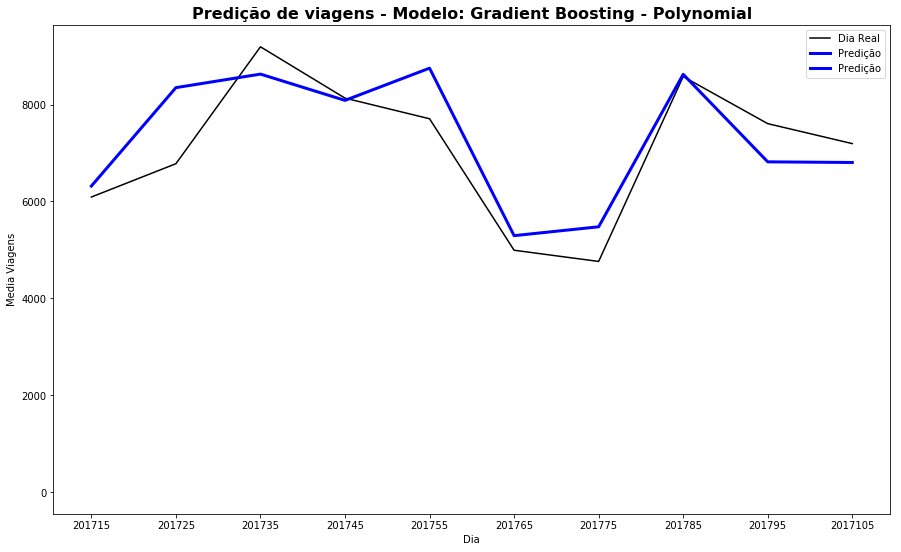

In [26]:
#Validation ###################################################
# create polynomial terms
train_poly, valid_poly = bs_create_polynomial_terms(X_train, X_valida, 2)
# Unlike simple linear regression, ridge regularization requires scaled data
train_scaled, valid_scaled = bs_scale_mean_std(train_poly, valid_poly)


plot_chart_predict(x_plot2, bot=120,top=130,model=clf8,x_test=valid_scaled,y_test=y_valida,desc="Gradient Boosting - Polynomial")

In [27]:
################## GBR with parameter estimation with cross-validation

# create polynomial terms
train_poly, test_poly = bs_create_polynomial_terms(X_train, X_test, 3)

# Unlike simple linear regression, ridge regularization requires scaled data
train_scaled, test_scaled = bs_scale_mean_std(train_poly, test_poly)


# create polynomial terms
train2_poly, valid_poly = bs_create_polynomial_terms(X_train, X_valida, 3)

# Unlike simple linear regression, ridge regularization requires scaled data
train2_scaled, valid_poly = bs_scale_mean_std(train2_poly, valid_poly)


# Create linear regression object
t_clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, 
                                max_depth=3, loss='ls')
                                
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
param_range_n_estimators = [500, 1000, 2000]
param_range_max_depth = [1, 3, 5]

param_grid = [{'n_estimators': param_range_n_estimators,
              'max_depth': param_range_max_depth}]

# we will not define optional 'scoring' parameter. It will use lsr for scoring
# read here for detail of scoring for classification and regression grid search
# http://scikit-learn.org/stable/modules/grid_search.html
# https://github.com/scikit-learn/scikit-learn/blob/51a765a/sklearn/metrics/regression.py#L370
clf10 = GridSearchCV(estimator=t_clf, param_grid=param_grid, cv=5, n_jobs=4)
                 
# get fitted regresser
clf10 = bs_fit_and_save(clf10, train_scaled, y_train, test_scaled, "output_gbm_cv_poly_3") # this will take some time

Residual sum of squares: 0.00
Variance score: 1.00


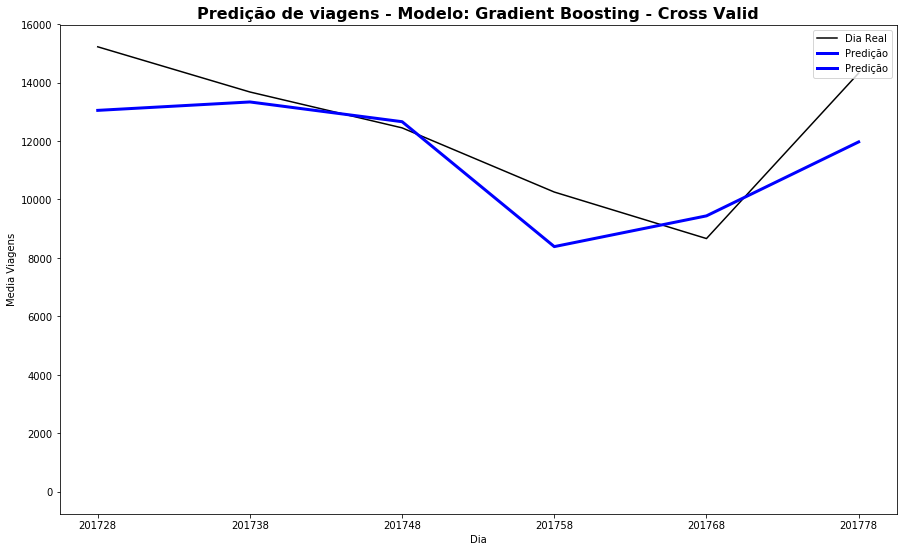

In [28]:
plot_chart_predict(x__plot=x_plot2, bot=213,top=219,model=clf10,x_test=valid_poly,y_test=y_valida,desc="Gradient Boosting - Cross Valid")